In [2]:
import random
import math
import heapq
import time
import matplotlib.pyplot as plt
from collections import deque, defaultdict

In [3]:
import nbimporter
from graph_utilities import calculer_voisinage_etendu
from graph_utilities import lire_graphe, afficher_graphe, visualiser_graphe_par_etape
from graph_utilities import generate_cyclic_graph, generate_chain_graph, generate_spider_graph

prends en paramètre un graphe dans un état (càd avec des sommets brulés) et retourne le graphe dans l'état suivante

test_but : vérifie si tout les sommets sont brulées

In [4]:
def test_but(etat_actuel):
    """
    Vérifie si tous les sommets sont brûlés.
    """
    return all(val == 1 for val in etat_actuel.values())

## 1ère méthode

In [5]:
def choisir_sommet_aleatoire(etat_actuel):
    sommets_non_brules = [sommet for sommet, etat in etat_actuel.items() if etat == 0]
    return random.choice(sommets_non_brules) if sommets_non_brules else None


In [6]:
def successeurs_p(graphe, etat_actuel):
    """
    Génère l'état suivant en propageant la brûlure aux voisins des sommets déjà brûlés.
    :param graphe: Le graphe sous forme de dictionnaire.
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets (brûlés ou non brûlés).
    :return: Nouveau dictionnaire représentant l'état des sommets après propagation.
    """

    brulage = False  # Indique si un sommet a été brûlé dans cet appel de la fonction

    # Copier l'état actuel pour générer le nouvel état
    nouvel_etat = etat_actuel.copy()

    # Récupérer tous les sommets brûlés
    sommets_brules = [sommet for sommet, etat in nouvel_etat.items() if etat == 1]

    # Propager la brûlure aux voisins des sommets brûlés
    for sommet in sommets_brules:
        for voisin in graphe.get(sommet, []):  # Obtenir les voisins dans la liste d'adjacence
            if nouvel_etat[voisin] == 0:  # Brûler uniquement les sommets non brûlés
                nouvel_etat[voisin] = 1
                brulage = True

    return nouvel_etat, brulage

In [7]:
def choisir_sommet_a_bruler(graphe, etat_actuel):
    """
    Sélectionne un sommet non brûlé ayant le maximum de voisins.
    
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets.
    :return: Le sommet non brûlé avec le maximum de voisins, ou None si aucun sommet disponible.
    """
    # Trouver les sommets non brûlés
    sommets_non_brules = [sommet for sommet, etat in etat_actuel.items() if etat == 0]
    
    if not sommets_non_brules:
        # Aucun sommet non brûlé
        return None

    # Trouver le sommet avec le maximum de voisins
    sommet_max_voisins = max(sommets_non_brules, key=lambda sommet: len(graphe.get(sommet, [])))

    return sommet_max_voisins


In [8]:
def recherche_profondeur(graphe):
    """
    Algorithme générique de recherche pour brûler un graphe en choisissant un sommet par étape.
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :param etat_initial: Dictionnaire représentant l'état initial des sommets (brûlés ou non brûlés).
    :param successeurs: Fonction qui génère l'état suivant (propagation).
    :param test_but: Fonction qui vérifie si tous les sommets sont brûlés.
    :return: Chemin (liste des états successifs), sommets brûlés activement à chaque étape, et coût total.
    """
    # Initialisation : créer la liste des états à traiter
    etat_initial = {sommet: 0 for sommet in graphe}
    etats_a_traiter = deque([{"etat": etat_initial, "cout": 1, "brules_actifs": []}])

    while etats_a_traiter:
        # Extraire un état
        noeud = etats_a_traiter.pop()

        noeud["etat"], brulage = successeurs_p(graphe, noeud["etat"])

        if brulage:
            noeud["cout"] += 1  # Chaque étape coûte 1

        # Vérifier si tous les sommets sont brûlés
        if test_but(noeud["etat"]):
            return noeud["brules_actifs"], noeud["cout"]

        # Choisir un nouveau sommet à brûler activement
        nouveau_sommet = choisir_sommet_a_bruler(graphe, noeud["etat"])
        #nouveau_sommet = choisir_sommet_aleatoire(noeud["etat"])
        if nouveau_sommet is None:
            # Si aucun sommet à brûler n'est disponible, retourner l'état actuel
            continue

        # Copier l'état courant
        etat_suivant = noeud["etat"].copy()

        # Marquer le sommet comme "brûlé"
        etat_suivant[nouveau_sommet] = 1

        # Ajouter le nouvel état à la liste des états à traiter
        etats_a_traiter.append({
            "etat": etat_suivant,
            "cout": noeud["cout"],  # Chaque étape coûte 1
            "brules_actifs": noeud["brules_actifs"] + [nouveau_sommet]
        })

    # Si aucun état final n'est trouvé
    return [], float("inf")


etape 1 :

parcours en largeur : popleft de la liste des états à traiter

parcours en largeur itéré : livre artificial intelligence section 3.4.4 et 3.4.5


etape 2 : couverture des balles

appliquer le A* dans le parcours

bruler ce noeuds pendant un certain temps
=> couverture par des balles

l'ensemble des action : 
le cout : la taille de la grande balle
fixer burning number dés le début (6)


# 2éme méthode

In [9]:
def propager(graphe, etat_actuel, cout_actuel):
    """
    Propage la brûlure aux voisins des sommets déjà brûlés (un "pas" de propagation),
    en incrémentant le coût à chaque fois qu'un nouveau sommet est enflammé.
    
    Retourne (nouvel_etat, cout_apres_propagation).
    """
    nouvel_etat = etat_actuel.copy()
    
    # Récupérer tous les sommets brûlés
    sommets_brules = [s for s, etat in nouvel_etat.items() if etat == 1]

    # Propager la brûlure aux voisins
    for sommet in sommets_brules:
        for voisin in graphe.get(sommet, []):
            if nouvel_etat[voisin] == 0:  # s’il n’était pas brûlé
                nouvel_etat[voisin] = 1
                #cout_actuel += 1  # Incrémenter le coût de propagation

    return nouvel_etat, cout_actuel

In [10]:
def successeurs(graphe, etat_actuel, cout_actuel):
    """
    Génère TOUS les états possibles en allumant manuellement
    chaque sommet non brûlé, puis en propageant le feu.
    
    Pour chacun, on renvoie le triplet (action, nouvel_etat, cout_action),
    où:
      - action       = le sommet qu'on a allumé
      - nouvel_etat  = l'état après allumage + propagation
      - cout_action  = le coût "supplémentaire" induit par cet allumage (et sa propagation)
    """
    liste_succ = []
    
    # Pour chaque sommet non brûlé, on simule "allumer ce sommet"
    for sommet in graphe:
        if etat_actuel[sommet] == 0:
            # 1) On copie l'état
            nouvel_etat = etat_actuel.copy()
            
            # 3) On propage la brûlure (un "pas" de propagation)
            nouvel_etat_propage, nouveau_cout = propager(graphe, nouvel_etat, cout_actuel)
            
            # 2) On allume manuellement ce sommet
            nouvel_etat_propage[sommet] = 1
            
            # 4) Le "coût d'action" = la différence entre le coût après et avant
            #    (autrement dit, combien on a dû payer en plus pour cet allumage + propagation)
            #cout_action = nouveau_cout - cout_actuel
            cout_action = 1
            
            # 5) On ajoute ce successeur à la liste
            liste_succ.append( (sommet, nouvel_etat_propage, cout_action) )
    
    return liste_succ

In [11]:
def recherche_largeur(graphe):
    """
    Traduit directement le pseudo-code "Algorithme 1" en Python,
    en utilisant la fonction 'successeurs' (qui retourne des triplets)
    et 'test_but'.
    
    :param graphe:        dictionnaire {sommet: [voisins]}
    :param etat_initial:  dictionnaire {sommet: 0/1}
    :param successeurs:   fonction(etat, cout) -> liste de (action, etat_suivant, cout_action)
    :param test_but:      fonction(etat) -> bool
    :return: (etat_solution, chemin_actions, cout_total) 
             ou (None, [], float("inf")) si on ne trouve pas de solution
    """
    etat_initial = {sommet: 0 for sommet in graphe}

    # 1) Construire le nœud initial = (état=etat_initial, chemin=[], coût=0)
    noeud_initial = {
        "etat": etat_initial,
        "chemin": [],
        "cout": 0
    }
    
    # 2) Mettre le nœud initial dans une file FIFO
    file = deque([noeud_initial])
    
    # 3) Tant que la file n'est pas vide
    while file:
        noeud = file.popleft()
        etat_courant = noeud["etat"]
        chemin_courant = noeud["chemin"]
        cout_courant = noeud["cout"]
        
        # -- Test but --
        if test_but(etat_courant):
            return etat_courant, chemin_courant, cout_courant
        
        # -- Parcourir tous les successeurs --
        #    successeurs(...) doit retourner [(action, etat_suivant, cout_action), ...]
        for (action, etat_suivant, cout_action) in successeurs(graphe, etat_courant, cout_courant):
            # Nouveau coût
            nouveau_cout = cout_courant + cout_action
            # Nouveau chemin
            nouveau_chemin = chemin_courant + [action]
            
            # Créer le noeud successeur
            noeud_suivant = {
                "etat": etat_suivant,
                "chemin": nouveau_chemin,
                "cout": nouveau_cout
            }
            # L'insérer dans la file
            file.append(noeud_suivant)
    
    # 4) Si on sort de la boucle, pas de solution trouvée
    return None, [], float("inf")

---

### Suite

In [12]:
# 10 sommets (3.16)
stranke = lire_graphe(r'instances\Stranke94\Stranke94.mtx')

# 29 sommets (5.38)
mouse = lire_graphe(r'instances\bn-mouse_visual-cortex_1\bn-mouse_visual-cortex_1.mtx')

# 34 sommets (5,83)
karate = lire_graphe(r'instances\karate\karate.mtx')

# 62 sommets (7.87)
dolphins = lire_graphe(r'instances\dolphins\dolphins.mtx')

# 105 sommets (12.88)
polbooks = lire_graphe(r'instances\polbooks\polbooks.mtx')

# 258 sommets (16.06)
sphere3 = lire_graphe(r'instances\sphere3\sphere3.mtx')

# 379 sommets (19.47)
netscience = lire_graphe(r'instances\ca-netscience\ca-netscience.mtx')

# 7057 sommets (84.005)
government = lire_graphe(r'instances\fb-pages-government\fb-pages-government.mtx')

# 11631 sommets (107.84)
crocodile = lire_graphe(r'instances\web-wiki-crocodile\web-wiki-crocodile.mtx')

# 196 591 sommets (443.38)
gowalla_edges = lire_graphe(r'instances\loc-gowalla_edges\loc-gowalla_edges.mtx')

In [13]:
# Graphe cyclique (4)
cylcle = generate_cyclic_graph(16)

# Graphe en chaîne (4)
chaine = generate_chain_graph(9)

# Graphe en étoile/spider (4.58)
etoile = generate_spider_graph(0, leg_length=4, num_legs=5)

In [15]:
sommets_actifs_p, cout = recherche_profondeur(karate)

print("*********** Parcours en profondeur ***********")
print("Sommets brûlés à chaque étape:", sommets_actifs_p)
print("Coût total:", cout)

*********** Parcours en profondeur ***********
Sommets brûlés à chaque étape: [34, 1, 17]
Coût total: 3


In [16]:
etat, sommets_actifs_l, cout = recherche_largeur(karate)

print("*********** Parcours en largeur ***********")
print("Sommets brûlés à chaque étape:", sommets_actifs_l)
print("Coût total:", cout)

*********** Parcours en largeur ***********
Sommets brûlés à chaque étape: [1, 33, 27]
Coût total: 3


dire un sommet va etre brulé au 3 tour par exemple
notre solution (du 2eme algo) sera le  centre (sommet) de la boule ayant le rayon le plus grand

# Couverture des balles

### Définition clarifiée des balles :
1. **Rayon de la balle** :
   - Le rayon $ r $ détermine combien de niveaux de voisins (profondeur dans le graphe) la balle peut atteindre depuis son centre $ U $.
   - Par exemple :
     - Rayon 1 : Brûle uniquement les voisins directs de $ U $.
     - Rayon 2 : Brûle les voisins de $ U $ et les voisins des voisins de $ U $.

2. **Centre de la balle** :
   - Chaque balle a un centre $ U $, qui est un sommet du graphe. À partir de ce centre, la brûlure se propage jusqu’à une profondeur $ r $.

3. **Objectif** :
   - Trouver un ensemble de balles ($ U_i, r_i $) qui couvrent **tout le graphe**.
   - Chaque sommet du graphe doit être brûlé par au moins une balle.

4. **Contraintes** :
   - Les **rayons des balles doivent être différents**.
   - Toutes les combinaisons possibles de balles (centres et rayons) doivent être explorées pour garantir que le graphe est entièrement couvert.

5. **Propagation de la brûlure** :
   - La propagation de la brûlure à une profondeur $ r $ peut être simulée par un parcours en largeur (BFS) depuis le sommet $ U $, en limitant la profondeur de l’exploration à $ r $.

---

n <- nombre de sommet dans le graphe
r <- math.ceil(math.sqrt(n))
s <- sommet ayant le max de voisins pour commencer

tant que graphe non brulé :
    bruler graphe depuis sommet s avec rayon r
    si tout graphe est brulé :
        retourner (s,r)
    sinon :
        stocker dans la liste (s,r)
        bruler graphe depuis sommet s avec rayon r
        r <- r-1
        sb_base <- calculer nombre sommet non brulé
        pour tout sommet u non brulés :
            bruler graphe depuis u avec rayon r
            sb <- calculer nombre sommet non brulé associé au sommet u
            si tout graphe est brulé :
                r <- r-1
            sinon si sb < sb_base :
                sb_base <- sb
                u_base <- u

In [17]:
def bruler(graphe, u, r):
    """
    Effectue une BFS depuis le sommet u en limitant la profondeur à r.
    Retourne l'ensemble des sommets brûlés (atteints).
    """
    visited = {u}
    queue = deque([(u, 0)])  # (sommet, profondeur)
    while queue:
        current, depth = queue.popleft()
        if depth < r:
            for neighbor in graphe.get(current, []):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, depth + 1))
    return visited

In [69]:
def iterations_brulage_totale(graphe, chemin):
    """
    Retourne le nombre d'itérations nécessaires pour que tous les sommets du graphe soient brûlés.
    Optimisé pour de grands graphes en utilisant des entiers pour représenter l'état :
      0 : non brûlé
      1 : en attente de brûlage (jaune)
      2 : brûlé (rouge)
    
    :param graphe: Dictionnaire représentant le graphe (liste d'adjacence).
    :param chemin: Liste des sommets choisis comme sources de feu.
    :return: Nombre d'itérations pour brûler entièrement le graphe.
    """
    total = len(graphe)
    # Initialisation: tous les sommets sont en état 0 (non brûlés)
    state = {sommet: 0 for sommet in graphe}
    burned = set()   # Ensemble des sommets brûlés (état 2)
    to_burn = set()  # Ensemble des sommets en attente de brûlage (état 1)
    iteration = 0

    while len(burned) < total:
        iteration += 1
        new_burned = set()
        
        # Ajout de la source externe pour cette itération, si disponible
        if iteration <= len(chemin):
            source = chemin[iteration - 1]
            if state[source] != 2:
                state[source] = 2
                burned.add(source)
                new_burned.add(source)
        
        # Les sommets en attente (état 1) deviennent brûlés (état 2)
        if to_burn:
            new_burned |= to_burn
            for node in to_burn:
                state[node] = 2
            burned |= to_burn
            to_burn.clear()
        
        # Propagation du feu : depuis chaque nouveau sommet brûlé, colorier les voisins non brûlés
        for node in new_burned:
            for voisin in graphe[node]:
                if state[voisin] == 0:
                    state[voisin] = 1
                    to_burn.add(voisin)
    
    return iteration


In [70]:
def couverture_balle(graphe):
    """
    Cherche une séquence de balles (centre, rayon) qui couvre entièrement le graphe.
    
    Contraintes :
      - Les rayons possibles sont 1, 2, ..., ⌈√n⌉ où n = nombre de sommets.
      - Un même rayon ne peut être utilisé qu'une seule fois dans une solution.
      - On explore d'abord les grandes valeurs de rayon (pour potentiellement réduire
        rapidement le nombre de balles et/ou le rayon maximal utilisé).
      
    Retourne la séquence des balles (centre, rayon) de la solution trouvée.
    """

    n = len(graphe)
    V = list(graphe.keys())
    best_sequence = None
    best_max_r = float('inf')
    best_num_balls = float('inf')
    max_rayon_possible = math.ceil(math.sqrt(n))
    #max_rayon_possible = round(math.sqrt(n))
    
    # File de priorité (heap) avec pour chaque état :
    # (heuristique, rayon_max_actuel, nombre_de_balles, sommets_brulés, séquence, rayons_utilisés)
    heap = []
    heapq.heappush(heap, (0, 0, 0, set(), [], set()))
    
    # Dictionnaire de mémorisation pour éviter de revisiter des états moins optimaux
    memo = defaultdict(lambda: (float('inf'), float('inf')))
    
    while heap:
        heur, current_max_r, current_num, brules, seq, used_r = heapq.heappop(heap)
        
        # Élagage : si l'état courant est moins bon que la meilleure solution trouvée, on passe
        # On passe cette branche si l'on sait déjà qu'elle est moins bonne que la meilleure solution trouvée
        if current_max_r > best_max_r or (current_max_r == best_max_r and current_num >= best_num_balls):
            continue
        
        # Si tous les sommets sont brûlés, on met à jour la meilleure solution
        if len(brules) == n:
            if current_max_r < best_max_r or (current_max_r == best_max_r and current_num < best_num_balls):
                best_max_r, best_num_balls, best_sequence = current_max_r, current_num, seq
            continue
        
        # Pour chaque sommet non brûlé, on essaie de l'étendre avec différents rayons
        for v in V:
            if v not in brules:
                # On ne considère pas un rayon supérieur à celui maximum autorisé
                # ni supérieur à best_max_r (pour rester dans une solution potentiellement optimale)
                max_possible_r = min(max_rayon_possible, best_max_r)
                # On explore les grands rayons en premier
                for r in range(max_possible_r - 1, -1, -1): # source de problèèèèèmes
                    # faire un vecteur de rayons utilisés
                    # used_r = [0 for _ in range(max_rayon_possible + 1)]
                    # used_r = [1,1,0,1]
                    if r in used_r:
                        continue  # Ce rayon a déjà été utilisé dans la séquence courante
                    
                    # Calcul à la demande des sommets brûlés par la balle (v, r)
                    burned_with_ball = bruler(graphe, v, r)
                    nouveaux_brules = brules | burned_with_ball
                    new_max_r = max(current_max_r, r)
                    new_num = current_num + 1
                    
                    # Clé pour mémorisation : combinaison des sommets brûlés et des rayons utilisés
                    key = (frozenset(nouveaux_brules), frozenset(used_r | {r}))
                    if (new_max_r, new_num) >= memo[key]:
                        continue
                    memo[key] = (new_max_r, new_num)
                    
                    # Heuristique : rayon maximal utilisé + fraction des sommets restants
                    # l'algorithme donne plus de poids à la minimisation du rayon maximal, mais prend aussi en compte la progression.
                    remaining = n - len(nouveaux_brules)
                    heuristic = new_max_r + (remaining / n)
                    heapq.heappush(heap, (heuristic, new_max_r, new_num, nouveaux_brules, seq + [(v, r)], used_r | {r}))
    
    
    # Optionnel : trier la séquence par rayon décroissant (similaire à la version initiale)
    res = sorted(best_sequence, key=lambda x: x[1], reverse=True)
    #res = [(center, rayon + 1) for center, rayon in res]
    bn = iterations_brulage_totale(graphe, [center for center, rayon in res])
    return res, bn


In [19]:
def couverture_balle_zero_un(graphe):
    """
    Cherche une séquence de balles (centre, rayon) qui couvre entièrement le graphe.
    
    Contraintes :
      - Les rayons possibles sont 1, 2, ..., ⌈√n⌉ où n = nombre de sommets.
      - Un même rayon ne peut être utilisé qu'une seule fois dans une solution.
      - On explore d'abord les grandes valeurs de rayon (pour potentiellement réduire
        rapidement le nombre de balles et/ou le rayon maximal utilisé).
      
    Retourne la séquence des balles (centre, rayon) de la solution trouvée.
    """

    n = len(graphe)
    V = list(graphe.keys())
    best_sequence = None
    best_max_r = float('inf')
    best_num_balls = float('inf')
    max_rayon_possible = math.ceil(math.sqrt(n))
    #max_rayon_possible = round(math.sqrt(n))
    
    # File de priorité (heap) avec pour chaque état :
    # (heuristique, rayon_max_actuel, nombre_de_balles, sommets_brulés, séquence, rayons_utilisés)
    heap = []
    initial_used_r = [0] * max_rayon_possible
    heapq.heappush(heap, (0, 0, 0, set(), [], initial_used_r))
    
    # Dictionnaire de mémorisation pour éviter de revisiter des états moins optimaux
    memo = defaultdict(lambda: (float('inf'), float('inf')))
    
    while heap:
        heur, current_max_r, current_num, brules, seq, used_r = heapq.heappop(heap)
        
        # Élagage : si l'état courant est moins bon que la meilleure solution trouvée, on passe
        # On passe cette branche si l'on sait déjà qu'elle est moins bonne que la meilleure solution trouvée
        if current_max_r > best_max_r or (current_max_r == best_max_r and current_num >= best_num_balls):
            continue
        
        # Si tous les sommets sont brûlés, on met à jour la meilleure solution
        if len(brules) == n:
            if current_max_r < best_max_r or (current_max_r == best_max_r and current_num < best_num_balls):
                best_max_r, best_num_balls, best_sequence = current_max_r, current_num, seq
            continue
        
        # Pour chaque sommet non brûlé, on essaie de l'étendre avec différents rayons
        for v in V:
            if v not in brules:
                # On ne considère pas un rayon supérieur à celui maximum autorisé
                # ni supérieur à best_max_r (pour rester dans une solution potentiellement optimale)
                max_possible_r = min(max_rayon_possible, best_max_r)
                # On explore les grands rayons en premier
                for r in range(max_possible_r, 0, -1):
                    if used_r[r-1]:
                        continue  # Ce rayon a déjà été utilisé dans la séquence courante
                    
                    # Calcul à la demande des sommets brûlés par la balle (v, r)
                    burned_with_ball = bruler(graphe, v, r)
                    nouveaux_brules = brules | burned_with_ball
                    new_max_r = max(current_max_r, r)
                    new_num = current_num + 1
                    
                    # Clé pour mémorisation : combinaison des sommets brûlés et des rayons utilisés
                    key = (frozenset(nouveaux_brules), frozenset(used_r | {r}))
                    if (new_max_r, new_num) >= memo[key]:
                        continue
                    memo[key] = (new_max_r, new_num)
                    
                    # Heuristique : rayon maximal utilisé + fraction des sommets restants
                    # l'algorithme donne plus de poids à la minimisation du rayon maximal, mais prend aussi en compte la progression.
                    remaining = n - len(nouveaux_brules)
                    heuristic = new_max_r + (remaining / n)
                    heapq.heappush(heap, (heuristic, new_max_r, new_num, nouveaux_brules, seq + [(v, r)], used_r | {r}))
    
    
    # Optionnel : trier la séquence par rayon décroissant (similaire à la version initiale)
    res = sorted(best_sequence, key=lambda x: x[1], reverse=True)
    res = [(center, rayon + 1) for center, rayon in res]
    return res


In [73]:
couverture_balle(mouse)

([(28, 3), (10, 1)], 4)

## Comparaison des heuristiques

### Heuristique multiplicative

In [22]:
def heuristique_multiplicative(current_max_r, current_num, brules, n, graphe):
    """
    Heuristique par défaut :
      - current_max_r : le rayon maximal utilisé jusqu'à présent.
      - brules : l'ensemble des sommets déjà "brûlés".
      - n : le nombre total de sommets.
    
    Renvoie une valeur heuristique qui combine le rayon maximal et
    la fraction des sommets non encore couverts.
    """
    remaining = n - len(brules)
    return current_max_r + (1 + (remaining / n))


### Heuristique quadratique sur la couverture restante

In [23]:
def heuristique_quadratique(current_max_r, current_num, brules, n, graphe):
    """
    Calcule l'heuristique en utilisant un terme quadratique sur la fraction restante.
      h = current_max_r + (remaining/n)²
    Cette formulation peut favoriser les états ayant couvert une partie importante du graphe.
    """
    remaining = n - len(brules)
    return current_max_r + (remaining / n) ** 2


### Heuristique combinant rayon et nombre de balles utilisées

In [24]:
def heuristique_combine(current_max_r, current_num, brules, n, graphe):
    """
    Heuristique combinée qui prend en compte :
      - Le rayon maximal utilisé,
      - Le nombre de balles posées,
      - La fraction de sommets non couverts.
    Le choix des coefficients (ici 0.5) peut être ajusté selon l'importance que vous souhaitez donner à chaque critère.
      h = current_max_r + 0.5 * current_num + (remaining / n)
    """
    remaining = n - len(brules)
    return current_max_r + 0.5 * current_num + (remaining / n)


### Heuristique basée sur le degré moyen des sommets non couverts

In [25]:
def heuristique_degre(current_max_r, current_num, brules, n, graphe):
    """
    Calcule l'heuristique en tenant compte du degré moyen des sommets non couverts.
    
    L'idée est que si les sommets restants ont un degré élevé, ils
    devraient être plus faciles à couvrir. On pénalise donc moins ces états.
    
    Paramètres :
      - current_max_r : le rayon maximal utilisé jusqu'à présent.
      - brules : ensemble des sommets déjà couverts.
      - n : nombre total de sommets.
      - graphe : dictionnaire représentant le graphe (pour accéder aux voisins).
    
    Retourne une valeur heuristique.
    """
    remaining = set(graphe.keys()) - brules
    if not remaining:
        return current_max_r
    avg_deg = sum(len(graphe[v]) for v in remaining) / len(remaining)
    # On pénalise moins si le degré moyen est élevé
    penalty = (len(remaining) / n) / (avg_deg + 1)
    return current_max_r + penalty


### fonction couverture de balle adapté

In [ ]:
def couverture_balle_beta(graphe, heuristique_func):
    """
    Cherche une séquence de balles (centre, rayon) qui couvre entièrement le graphe.
    
    Contraintes :
      - Les rayons possibles sont 1, 2, ..., ⌈√n⌉ où n = nombre de sommets.
      - Un même rayon ne peut être utilisé qu'une seule fois dans une solution.
      - On explore d'abord les grandes valeurs de rayon.
    
    Paramètres :
      - graphe : dictionnaire représentant le graphe.
      - heuristique_func : fonction qui calcule l'heuristique à partir de (current_max_r, brules, n).
    
    Retourne la séquence des balles (centre, rayon) de la solution trouvée.
    """
    n = len(graphe)
    V = list(graphe.keys())
    best_sequence = None
    best_max_r = float('inf')
    best_num_balls = float('inf')
    max_rayon_possible = math.ceil(math.sqrt(n))
    
    # File de priorité (heap) contenant pour chaque état :
    # (heuristique, rayon_max_actuel, nombre_de_balles, sommets_brulés, séquence, rayons_utilisés)
    heap = []
    heapq.heappush(heap, (0, 0, 0, set(), [], set()))
    
    # Dictionnaire de mémorisation pour éviter de revisiter des états moins optimaux
    memo = defaultdict(lambda: (float('inf'), float('inf')))
    
    while heap:
        heur, current_max_r, current_num, brules, seq, used_r = heapq.heappop(heap)
        
        # Élagage : on passe si l'état courant est moins bon que la meilleure solution trouvée
        if current_max_r > best_max_r or (current_max_r == best_max_r and current_num >= best_num_balls):
            continue
        
        # Si tous les sommets sont brûlés, on met à jour la meilleure solution
        if len(brules) == n:
            if current_max_r < best_max_r or (current_max_r == best_max_r and current_num < best_num_balls):
                best_max_r, best_num_balls, best_sequence = current_max_r, current_num, seq
            continue
        
        # Pour chaque sommet non brûlé, on essaie de l'étendre avec différents rayons
        for v in V:
            if v not in brules:
                max_possible_r = min(max_rayon_possible, best_max_r)
                # On explore les grands rayons en premier
                for r in range(max_possible_r - 1, -1, -1):
                    if r in used_r:
                        continue  # Ce rayon a déjà été utilisé dans la séquence courante
                    
                    # Calcul à la demande des sommets brûlés par la balle (v, r)
                    burned_with_ball = bruler(graphe, v, r)  # fonction supposée définie ailleurs
                    nouveaux_brules = brules | burned_with_ball
                    new_max_r = max(current_max_r, r)
                    new_num = current_num + 1
                    
                    # Clé de mémorisation : combinaison des sommets brûlés et des rayons utilisés
                    key = (frozenset(nouveaux_brules), frozenset(used_r | {r}))
                    if (new_max_r, new_num) >= memo[key]:
                        continue
                    memo[key] = (new_max_r, new_num)
                    
                    # Utilisation de la fonction d'heuristique passée en argument
                    heuristic = heuristique_func(new_max_r, new_num, nouveaux_brules, n, graphe)
                    heapq.heappush(heap, (heuristic, new_max_r, new_num, nouveaux_brules, seq + [(v, r)], used_r | {r}))
    
    # Optionnel : trier la séquence par rayon décroissant et ajuster le rayon (si nécessaire)
    res = sorted(best_sequence, key=lambda x: x[1], reverse=True)
    #res = [(center, rayon + 1) for center, rayon in res]
    return res


In [27]:
couverture_balle_beta(karate, heuristique_multiplicative)

[(32, 3), (17, 1)]

In [28]:
couverture_balle_beta(karate, heuristique_quadratique)

[(32, 3), (17, 1)]

In [29]:
couverture_balle_beta(karate, heuristique_combine)

[(32, 3), (17, 1)]

In [30]:
couverture_balle_beta(karate, heuristique_degre)

[(32, 3), (17, 1)]

## couverture_balle_timing

In [76]:
def couverture_balle_beta_timing(graphe, heuristique_func):
    """
    Retourne la séquence finale (liste des couples (sommet, rayon+1)) et une liste 
    'burning_progress' contenant, pour chaque itération, un tuple (temps, current_max_r, best_max_r)
    qui permet de suivre l'évolution du burning number au fil du temps.

    - temps : temps écoulé depuis le démarrage.
    - current_max_r : le burning number du nœud extrait lors de l'itération.
    - best_max_r : le meilleur burning number (celui d'une solution complète) trouvé jusqu'alors.
    """
    import time, math, heapq
    from collections import defaultdict

    start_time = time.time()
    burning_progress = []  # Pour enregistrer la progression minimale : (temps, current_max_r, best_max_r)
    n = len(graphe)
    V = list(graphe.keys())
    
    best_sequence = None
    best_max_r = float('inf')
    best_num_balls = float('inf')
    max_rayon_possible = math.ceil(math.sqrt(n))
    
    # File de priorité : chaque élément est un tuple
    # (heuristique, current_max_r, current_num, brules, seq, used_r)
    heap = []
    heapq.heappush(heap, (0, 0, 0, set(), [], set()))
    memo = defaultdict(lambda: (float('inf'), float('inf')))
    
    while heap:
        heur, current_max_r, current_num, brules, seq, used_r = heapq.heappop(heap)
        current_time = time.time() - start_time
        
        # Enregistrement minimal à chaque itération
        burning_progress.append((current_time, current_max_r, best_max_r))
        
        # Abandon de cette branche si elle est moins prometteuse que la meilleure solution trouvée
        if current_max_r > best_max_r or (current_max_r == best_max_r and current_num >= best_num_balls):
            continue
        
        # Si la solution est complète (tous les sommets brûlés)
        if len(brules) == n:
            if current_max_r < best_max_r or (current_max_r == best_max_r and current_num < best_num_balls):
                best_max_r, best_num_balls, best_sequence = current_max_r, current_num, seq
            continue
        
        # Exploration des prochaines possibilités
        for v in V:
            if v not in brules:
                max_possible_r = min(max_rayon_possible, best_max_r)
                for r in range(max_possible_r - 1, -1, -1):
                    if r in used_r:
                        continue

                    # La fonction 'bruler' doit être définie et retourner l'ensemble des sommets brûlés
                    burned_with_ball = bruler(graphe, v, r)
                    nouveaux_brules = brules | burned_with_ball
                    new_max_r = max(current_max_r, r)
                    new_num = current_num + 1

                    key = (frozenset(nouveaux_brules), frozenset(used_r | {r}))
                    
                    if (new_max_r, new_num) >= memo[key]:
                        continue
                    memo[key] = (new_max_r, new_num)
                    
                    candidate_seq = seq + [(v, r)]
                    heuristic = heuristique_func(new_max_r, new_num, nouveaux_brules, n, graphe)
                    heapq.heappush(heap, (heuristic, new_max_r, new_num, nouveaux_brules, candidate_seq, used_r | {r}))
    
    final_time = time.time() - start_time
    # Enregistrement final de l'état optimal
    burning_progress.append((final_time, best_max_r, best_max_r))
    
    if best_sequence is None:
        return [], burning_progress
    
    # Ajustement final : augmentation de 1 du rayon pour le résultat final
    res = sorted(best_sequence, key=lambda x: x[1], reverse=True)
    #res = [(center, rayon + 1) for center, rayon in res]
    return res, burning_progress


In [32]:
def plot_multiple_burning_progress(burning_progress_list, labels):
    """
    Affiche la progression du burning number pour plusieurs heuristiques sur le même graphique.
    
    Paramètres :
      - burning_progress_list : liste de listes de tuples (temps, current_max_r, best_max_r)
                                Chaque élément correspond aux données d'une heuristique.
      - labels : liste de labels (chaîne de caractères) associée à chaque heuristique.
    """
    plt.figure(figsize=(20, 6))
    
    for bp, label in zip(burning_progress_list, labels):
        # Extraction des données
        times = [t for t, current, best in bp]
        current_values = [current for t, current, best in bp]
        best_values = [best for t, current, best in bp]

        
        # Trace la courbe et récupère l'objet Line2D pour obtenir la couleur utilisée
        line, = plt.plot(times, current_values, label=label, linestyle='--', marker='o')
        color = line.get_color()
        #plt.plot(times, best_values, linestyle='-', marker='o', markersize=10, color=color)

        
        
        # Marquer le dernier point avec un marqueur plus gros et de la même couleur
        if times and current_values:
            plt.plot(times[-1], current_values[-1], marker='o', color=color, markersize=15)
    
    plt.xlabel('Temps (secondes)')
    plt.ylabel('Burning Number')
    plt.title('Progression du Burning Number pour différentes heuristiques')
    plt.legend()
    plt.grid(True)
    plt.show()



In [33]:
def comparaison_heuristiques(graphe):
    """
    Compare les différentes heuristiques sur un même graphe.
    """
    heuristiques = [heuristique_multiplicative, heuristique_quadratique, heuristique_combine, heuristique_degre]
    labels = ['Multiplicative', 'Quadratique', 'Combine', 'Degré']
    burning_progress_list = []
    
    for heuristique in heuristiques:
        _, burning_progress = couverture_balle_beta_timing(graphe, heuristique)
        burning_progress_list.append(burning_progress)
    
    plot_multiple_burning_progress(burning_progress_list, labels)

### mouse

In [77]:
res, bn_p = couverture_balle_beta_timing(mouse, heuristique_multiplicative)

In [78]:
res

[(28, 3), (10, 1)]

In [80]:
bn_p[len(bn_p)-50:]

[(7.735965967178345, 4, 3),
 (7.735965967178345, 4, 3),
 (7.735965967178345, 4, 3),
 (7.735965967178345, 4, 3),
 (7.735965967178345, 4, 3),
 (7.735965967178345, 4, 3),
 (7.735965967178345, 4, 3),
 (7.735965967178345, 4, 3),
 (7.735965967178345, 4, 3),
 (7.735965967178345, 4, 3),
 (7.735965967178345, 4, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345, 5, 3),
 (7.735965967178345,

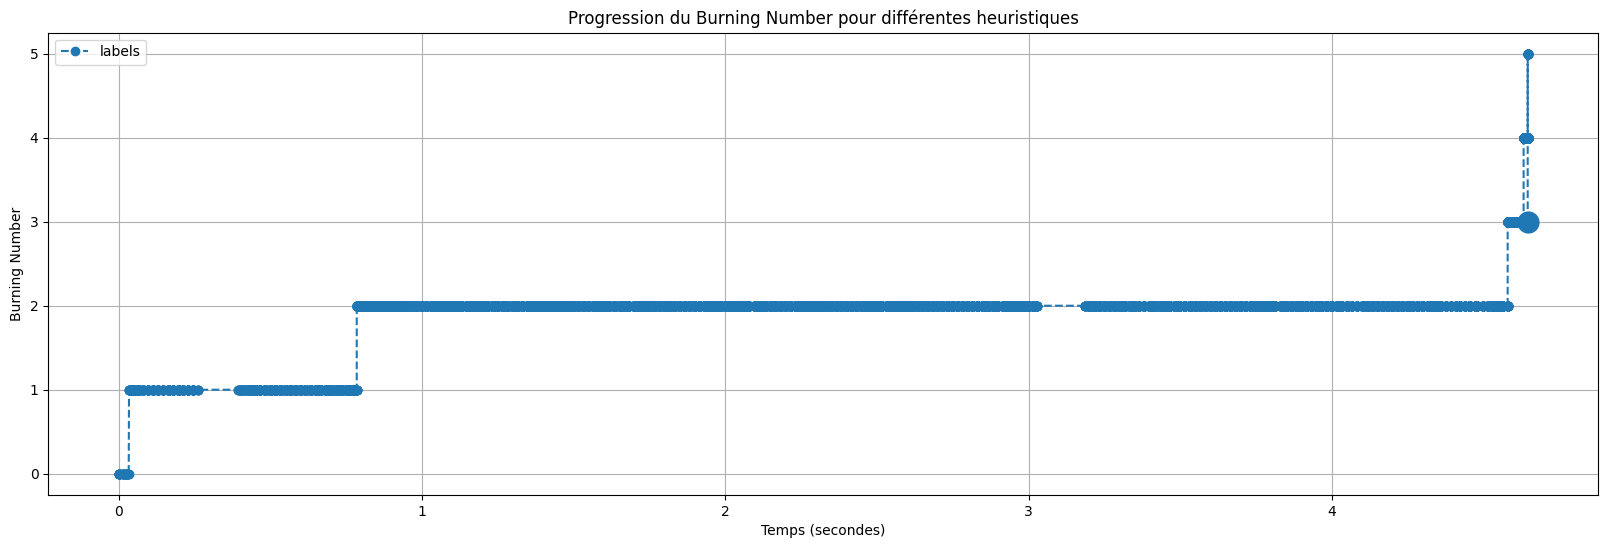

In [38]:
plot_multiple_burning_progress([bn_p], ["labels"])

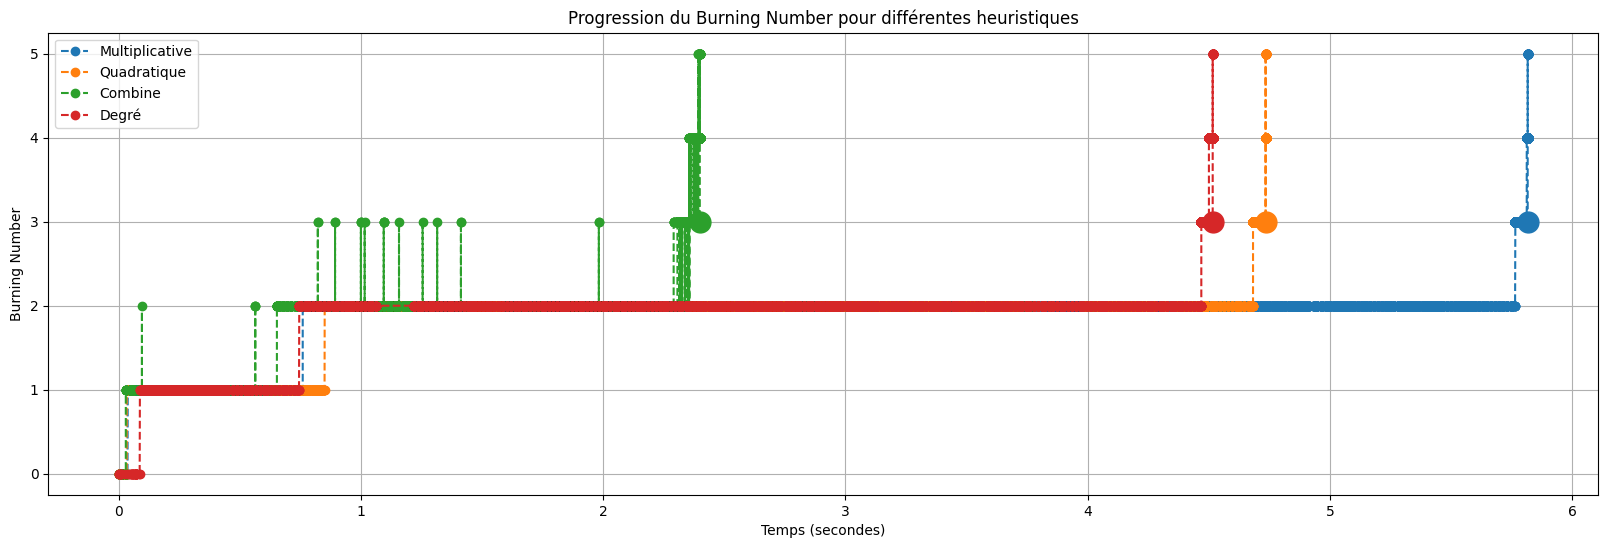

In [39]:
fichier = r'instances\bn-mouse_visual-cortex_1\bn-mouse_visual-cortex_1.mtx'
mouse = lire_graphe(fichier)
comparaison_heuristiques(mouse)

### karate

In [40]:
fichier = r'instances\karate\karate.mtx'
karate = lire_graphe(fichier)

In [54]:
res, bn_p = couverture_balle_beta_timing(karate, heuristique_multiplicative)

In [55]:
res

[(32, 3), (17, 1)]

In [57]:
bn_p[(len(bn_p) - 50):]

[(1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544, 4, 2),
 (1.917182207107544,

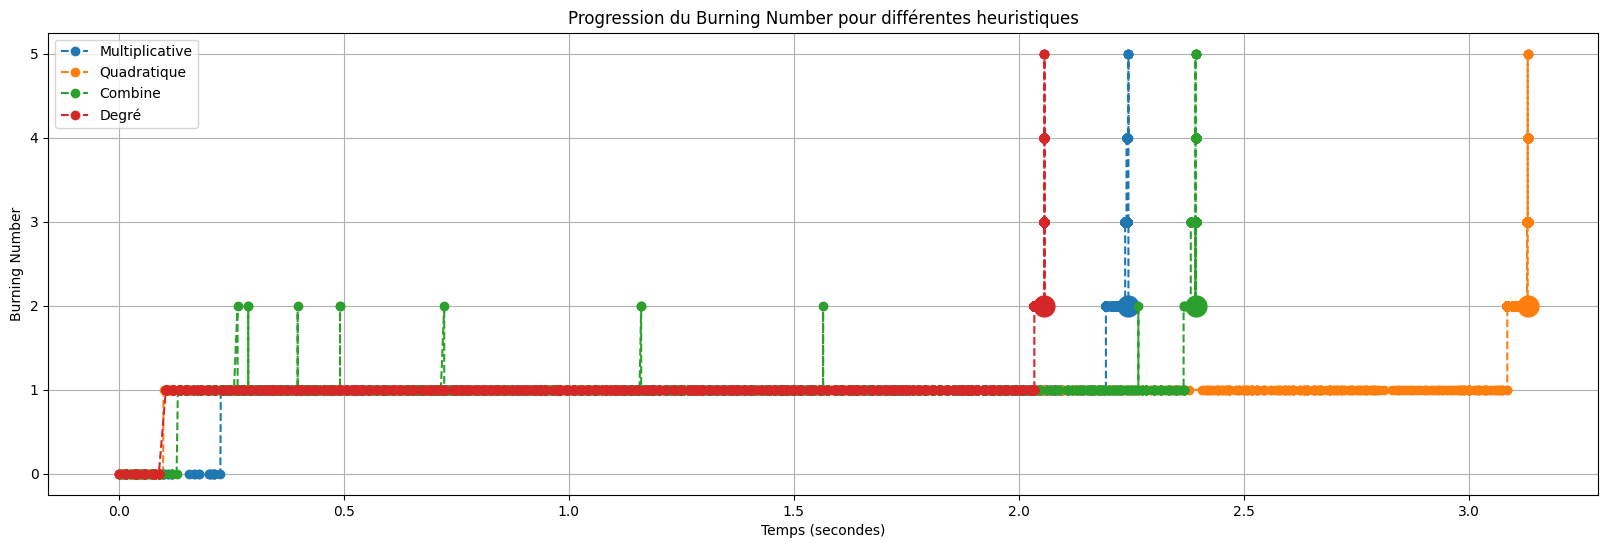

In [53]:
comparaison_heuristiques(karate)

In [45]:
couverture_balle_beta(chaine, heuristique_multiplicative)

[(6, 3), (2, 2), (0, 1)]

In [46]:
res, bn_pp = couverture_balle_beta_timing(chaine, heuristique_multiplicative)
res

[(0, 1), (2, 2), (6, 3)]

In [47]:
len(bn_pp)

230

In [48]:
bn_pp[214000:]

[]

In [49]:
couverture_balle(generate_chain_graph(25))

[(15, 5), (4, 4), (22, 3), (9, 2), (0, 1)]

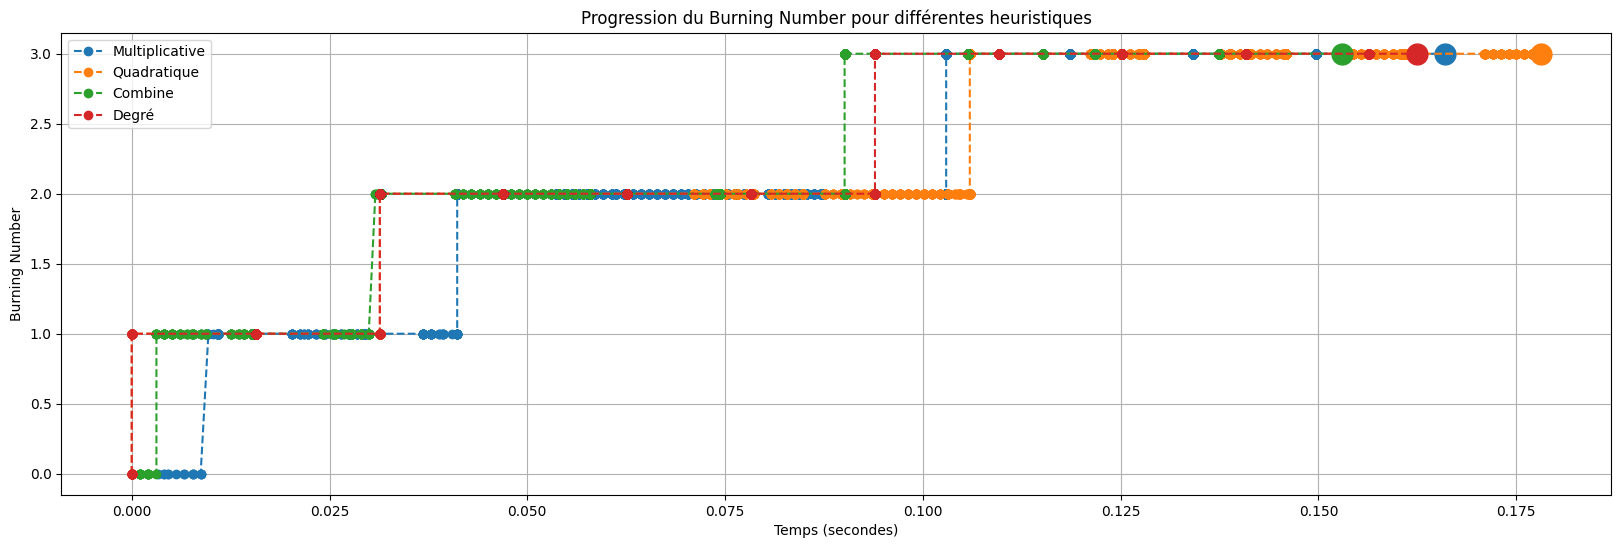

In [50]:
chaine = generate_chain_graph(16)
comparaison_heuristiques(chaine)

In [51]:
def plot_burning_progress_adatpted(burning_progress):
    """
    Affiche la progression du burning number à partir de la liste burning_progress.
    La fonction adapte automatiquement l'échelle du temps en fonction des données.
    
    burning_progress : liste de tuples (temps, current_max_r, best_max_r)
    """
    # Extraction des données
    times = [t for t, current, best in burning_progress]
    current_values = [current for t, current, best in burning_progress]
    best_values = [best for t, current, best in burning_progress]
    
    # Détermination de l'échelle adaptée
    max_time = max(times) if times else 0
    if max_time < 1:
        factor = 1000
        time_unit = "ms"
    elif max_time < 60:
        factor = 1
        time_unit = "s"
    elif max_time < 3600:
        factor = 1/60
        time_unit = "min"
    else:
        factor = 1/3600
        time_unit = "h"
    
    times_scaled = [t * factor for t in times]
    
    # Création du graphique
    plt.figure(figsize=(10, 6))
    plt.plot(times_scaled, current_values, label='Burning Number courant', linestyle='--', marker='o')
    plt.plot(times_scaled, best_values, label='Meilleur Burning Number', linestyle='-', marker='o')
    
    plt.xlabel(f'Temps ({time_unit})')
    plt.ylabel('Burning Number')
    plt.title('Progression du Burning Number au cours du temps')
    plt.legend()
    plt.grid(True)
    plt.show()

- imposer un limite de 10s -> faire la recherche pendant max 10s
- tester pour diff periode de temps, arreter après avoir passer cette periode de temps, et voir au bout de quel moment arrive à un solution optimale (ou meme comparer la qté de a solution)

=> figure : 
- x : periode d'exec
- y : burning number
- clé : diff graphe


(HPC serveur frontal de l'isima => faire assez de calcule en paralelle qu'on veux)

- bruler le graphe à un certain rayon et calculer ça connectivité 
- calculer le nbr de composant connexe ( à chercher ça def)
- diametre = le nbr de sommet entre les deux sommet les plus éloigné du graphe

objectif : relaxation linéaire pour les petits graphes